In [29]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
import dgl
import torch as th

from sklearn.preprocessing import LabelEncoder

### Préparation des interactions Client - Article

- Extraction de N identifiants utilisateurs 
- Split entre le jeu d'entraînement et de test
- Compilation des features

In [41]:
transactions = pd.read_pickle('pickles/transactions.pkl')
transactions = transactions.sample(frac = 0.01)

In [42]:
customers = pd.read_pickle('pickles/customers_second_iteration.pkl')
articles = pd.read_pickle('pickles/articles_second_iteration.pkl')

In [43]:
old_purchases = transactions[(transactions['week_number'] > 0) & (transactions['week_number'] < 50)]
purchases_to_predict = transactions[transactions['week_number'] == 0]

In [44]:
# Split customers into valid and train set.
customer_id_train, customer_id_valid = train_test_split(purchases_to_predict.customer_id.unique(), test_size = 0.2) 

valid_customers  = pd.DataFrame(customer_id_valid, columns = ['customer_id'])
valid_customers['validation_set'] = True

customers = customers.merge(valid_customers, on = 'customer_id', how = 'left')
customers['validation_set'].fillna(False, inplace = True)

In [45]:
# Only process concerned customers.
customer_id = pd.Series(transactions.customer_id.unique()).rename('customer_id')
customers = customers.merge(customer_id, on = 'customer_id', how = 'right')

In [46]:
# Only process concerned articles.
article_id = pd.Series(transactions.article_id.unique()).rename('article_id')
articles = articles.merge(article_id, on = 'article_id', how = 'right')

In [47]:
# Change indexes and save memory
articles = articles.reset_index().rename({"index": "article_nid"}, axis = 1)
customers = customers.reset_index().rename({"index": "customer_nid"}, axis = 1)

articles['article_nid'] = articles['article_nid'].astype('int32')
customers['customer_nid'] = customers['customer_nid'].astype('int32')

In [48]:
# Update edge lists with new IDs and validation set Tag.
old_purchases = old_purchases.merge(articles[['article_id', 'article_nid']], on = 'article_id', how = 'left')
old_purchases = old_purchases.merge(customers[['customer_id', 'customer_nid', 'validation_set']], on = 'customer_id', how = 'left')

purchases_to_predict = purchases_to_predict.merge(articles[['article_id', 'article_nid']], on = 'article_id', how = 'left')
purchases_to_predict = purchases_to_predict.merge(customers[['customer_id', 'customer_nid', 'validation_set']], on = 'customer_id', how = 'left')

In [49]:
old_purchases['day_number'] = (old_purchases['t_dat'].max() - old_purchases['t_dat'] ).dt.days

old_purchases = old_purchases.groupby(['customer_nid', 'article_nid'], as_index = False).agg(
    sales_channel_id = ('sales_channel_id', 'mean'),
    first = ('day_number', 'min'),
    last = ('day_number', 'max'),
    purchases = ('article_nid', 'count'),
)

old_purchases['mean_interval'] = ((old_purchases['last'] - old_purchases['first']) / old_purchases['purchases']).astype("int32")

In [50]:
purchase_list = purchases_to_predict.groupby('customer_nid').agg(
    list = ('article_nid', lambda x: list(x))
)
purchase_list


,list
customer_nid,
49,[48]
158,[40233]
213,[210]
344,[238]
358,[348]
...,...
214551,[2712]
214593,[52526]
214612,[2483]


In [18]:
graph_data = {
    ('customer', 'buys', 'article'):
        (
            th.tensor(old_purchases['customer_nid'].values),
            th.tensor(old_purchases['article_nid'].values) ,
        ),
    
    ('article', 'is-bought-by', 'customer'):
        (
            th.tensor(old_purchases['article_nid'].values),
            th.tensor(old_purchases['customer_nid'].values),
        ),
        
        
    ('customer', 'will-buy', 'article'):
        (
            th.tensor(purchases_to_predict['customer_nid'].values),
            th.tensor(purchases_to_predict['article_nid'].values),
        )
}

graph = dgl.heterograph(
    graph_data
)

In [20]:
customers[['FN', 'Active', 'age', 'average_cart_price']].values

array([[0.00000000e+00, 0.00000000e+00, 6.50000000e+01, 1.20279661e-01],
       [1.00000000e+00, 1.00000000e+00, 6.60000000e+01, 6.70220339e-02],
       [0.00000000e+00, 0.00000000e+00, 2.70000000e+01, 8.64830508e-02],
       ...,
       [1.00000000e+00, 1.00000000e+00, 2.60000000e+01, 5.28000000e-02],
       [0.00000000e+00, 0.00000000e+00, 2.30000000e+01, 5.10338983e-02],
       [0.00000000e+00, 0.00000000e+00, 2.30000000e+01, 3.25607345e-01]])

In [22]:
graph.nodes['customer'].data['features'] = th.tensor(customers[['FN', 'Active', 'age', 'average_cart_price']].values)

In [139]:
purchases_to_predict = purchases_to_predict.reset_index()  \
    .rename({'index': 'eid'}, axis = 1)
    
purchases_to_predict['eid'] = purchases_to_predict['eid'].astype('int32')

In [68]:
cuda = th.device('cuda')
graph.to(cuda)

Graph(num_nodes={'article': 187, 'customer': 83},
      num_edges={('article', 'is-bought-by', 'customer'): 100, ('customer', 'buys', 'article'): 100},
      metagraph=[('article', 'customer', 'is-bought-by'), ('customer', 'article', 'buys')])

In [144]:
sampler = dgl.dataloading.MultiLayerFullNeighborSampler(5)

neg_sampler = dgl.dataloading.as_edge_prediction_sampler(
    sampler, negative_sampler=dgl.dataloading.negative_sampler.Uniform(1))

dataloader = dgl.dataloading.DataLoader(
    graph, 
    {'customer': th.tensor([0,1,2,3,4,5,6,7,8,9,10], dtype = th.int32)}, 
    sampler,
    batch_size=1024,
    shuffle=True,
    drop_last=False)

negative_dataloader = dgl.dataloading.DataLoader(
    graph, 
    {
        'will-buy': th.tensor(purchases_to_predict[purchases_to_predict['validation_set'] == True].index.values, dtype = th.int32)
    },
    neg_sampler,
    batch_size=10,
    shuffle=True,
    drop_last=False,
    pin_memory=True)



In [145]:
input_nodes, positive_graph, negative_graph, blocks = next(iter(negative_dataloader))
print(blocks)


[Block(num_src_nodes={'article': 450, 'customer': 4320},
      num_dst_nodes={'article': 350, 'customer': 1356},
      num_edges={('article', 'is-bought-by', 'customer'): 1740, ('customer', 'buys', 'article'): 4576, ('customer', 'will-buy', 'article'): 97},
      metagraph=[('article', 'customer', 'is-bought-by'), ('customer', 'article', 'buys'), ('customer', 'article', 'will-buy')]), Block(num_src_nodes={'article': 350, 'customer': 1356},
      num_dst_nodes={'article': 98, 'customer': 1046},
      num_edges={('article', 'is-bought-by', 'customer'): 1326, ('customer', 'buys', 'article'): 1380, ('customer', 'will-buy', 'article'): 57},
      metagraph=[('article', 'customer', 'is-bought-by'), ('customer', 'article', 'buys'), ('customer', 'article', 'will-buy')]), Block(num_src_nodes={'article': 98, 'customer': 1046},
      num_dst_nodes={'article': 75, 'customer': 229},
      num_edges={('article', 'is-bought-by', 'customer'): 275, ('customer', 'buys', 'article'): 1050, ('customer', 'w

### Essai sur la métrique

In [53]:
import torch as th

customers_index = th.tensor([11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0])
articles_index = th.tensor([18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1])

customers = th.randn((12, 32))
articles = th.randn((18, 32))
cos = th.nn.CosineSimilarity(dim=1, eps=1e-6)


output = cos(
    customers.reshape(-1, 32, 1), 
    articles.reshape(1, 32, -1)
)
sorted = th.argsort(output, dim = 1, descending = True)
sorted = sorted[:, 0:12]

print(sorted)
print(articles_index[sorted[:]])

reindexed = articles_index[sorted[:]]

reindexed[customers_index]

tensor([[ 9, 11,  6,  4, 14, 13, 16, 10, 17,  0,  3,  8],
        [12,  2, 15, 16, 17,  9, 11,  4,  8,  6,  1,  7],
        [17,  2,  6, 16, 14, 12,  1,  9, 13, 15, 11,  4],
        [ 4, 10, 17,  2, 13,  9,  3, 12,  8,  0, 11,  5],
        [ 4,  3,  9,  0,  7,  8, 17,  6, 14,  5, 10, 13],
        [ 0, 15,  1,  2, 17, 11,  9, 14, 16, 12,  3,  6],
        [ 7,  6, 12, 10, 15,  8, 14,  1,  4,  0,  9, 11],
        [ 9,  8,  2, 16,  6, 15, 12,  1, 11,  0,  5,  7],
        [ 0, 11,  2, 12,  1, 15, 14,  5,  9, 16,  3,  6],
        [ 4,  1, 10,  0, 11,  5, 12,  7,  8,  6, 13,  9],
        [12,  8,  7,  4,  9, 10,  0, 14,  1,  3,  2, 11],
        [ 4,  3,  5, 16, 17, 10, 12,  7,  0, 13, 15,  2]])
tensor([[ 9,  7, 12, 14,  4,  5,  2,  8,  1, 18, 15, 10],
        [ 6, 16,  3,  2,  1,  9,  7, 14, 10, 12, 17, 11],
        [ 1, 16, 12,  2,  4,  6, 17,  9,  5,  3,  7, 14],
        [14,  8,  1, 16,  5,  9, 15,  6, 10, 18,  7, 13],
        [14, 15,  9, 18, 11, 10,  1, 12,  4, 13,  8,  5],
        [18, 

tensor([[14, 15, 13,  2,  1,  8,  6, 11, 18,  5,  3, 16],
        [ 6, 10, 11, 14,  9,  8, 18,  4, 17, 15, 16,  7],
        [14, 17,  8, 18,  7, 13,  6, 11, 10, 12,  5,  9],
        [18,  7, 16,  6, 17,  3,  4, 13,  9,  2, 15, 12],
        [ 9, 10, 16,  2, 12,  3,  6, 17,  7, 18, 13, 11],
        [11, 12,  6,  8,  3, 10,  4, 17, 14, 18,  9,  7],
        [18,  3, 17, 16,  1,  7,  9,  4,  2,  6, 15, 12],
        [14, 15,  9, 18, 11, 10,  1, 12,  4, 13,  8,  5],
        [14,  8,  1, 16,  5,  9, 15,  6, 10, 18,  7, 13],
        [ 1, 16, 12,  2,  4,  6, 17,  9,  5,  3,  7, 14],
        [ 6, 16,  3,  2,  1,  9,  7, 14, 10, 12, 17, 11],
        [ 9,  7, 12, 14,  4,  5,  2,  8,  1, 18, 15, 10]])

In [69]:
df = pd.Series(reindexed[customers_index].tolist()).rename('prediction')
pd.concat([df, df], axis = 1)

,prediction,prediction
0,"[14, 15, 13, 2, 1, 8, 6, 11, 18, 5, 3, 16]","[14, 15, 13, 2, 1, 8, 6, 11, 18, 5, 3, 16]"
1,"[6, 10, 11, 14, 9, 8, 18, 4, 17, 15, 16, 7]","[6, 10, 11, 14, 9, 8, 18, 4, 17, 15, 16, 7]"
2,"[14, 17, 8, 18, 7, 13, 6, 11, 10, 12, 5, 9]","[14, 17, 8, 18, 7, 13, 6, 11, 10, 12, 5, 9]"
3,"[18, 7, 16, 6, 17, 3, 4, 13, 9, 2, 15, 12]","[18, 7, 16, 6, 17, 3, 4, 13, 9, 2, 15, 12]"
4,"[9, 10, 16, 2, 12, 3, 6, 17, 7, 18, 13, 11]","[9, 10, 16, 2, 12, 3, 6, 17, 7, 18, 13, 11]"
5,"[11, 12, 6, 8, 3, 10, 4, 17, 14, 18, 9, 7]","[11, 12, 6, 8, 3, 10, 4, 17, 14, 18, 9, 7]"
6,"[18, 3, 17, 16, 1, 7, 9, 4, 2, 6, 15, 12]","[18, 3, 17, 16, 1, 7, 9, 4, 2, 6, 15, 12]"
7,"[14, 15, 9, 18, 11, 10, 1, 12, 4, 13, 8, 5]","[14, 15, 9, 18, 11, 10, 1, 12, 4, 13, 8, 5]"
8,"[14, 8, 1, 16, 5, 9, 15, 6, 10, 18, 7, 13]","[14, 8, 1, 16, 5, 9, 15, 6, 10, 18, 7, 13]"
9,"[1, 16, 12, 2, 4, 6, 17, 9, 5, 3, 7, 14]","[1, 16, 12, 2, 4, 6, 17, 9, 5, 3, 7, 14]"


In [60]:
transactions = transactions[['customer_id', 'article_id', 't_dat']]
transactions.rename({
    'customer_id': 'CUSTOMER IDENTIFIER',
    'article_id': 'SPECIFIC ITEM IDENTIFIER',
    't_dat': 'hit_date'
}, axis=1, inplace = True)
transactions['buy'] = 1
transactions = transactions[transactions['hit_date'] > "2019-09"]

In [38]:
# Stratégie de sampling : extraction de N identifiants utilisateurs au hasard
sampled_customer_ids = pd.Series(transactions['CUSTOMER IDENTIFIER'].unique()).sample(frac = 0.01).rename('CUSTOMER IDENTIFIER')

transactions_sampled = transactions.merge(sampled_customer_ids, on = "CUSTOMER IDENTIFIER", how = "inner")

In [39]:
transactions_sampled = transactions_sampled[transactions_sampled['hit_date'] > "2019-09"]
transactions_sampled

,CUSTOMER IDENTIFIER,SPECIFIC ITEM IDENTIFIER,hit_date,buy
29,f1dd5ce5010a105c4d63b5080ab66c6851b4ab75803173...,0799876001,2019-10-04,1
30,f1dd5ce5010a105c4d63b5080ab66c6851b4ab75803173...,0780418002,2019-10-04,1
31,f1dd5ce5010a105c4d63b5080ab66c6851b4ab75803173...,0393447015,2019-10-12,1
32,f1dd5ce5010a105c4d63b5080ab66c6851b4ab75803173...,0740210001,2019-10-12,1
33,f1dd5ce5010a105c4d63b5080ab66c6851b4ab75803173...,0650122001,2019-10-12,1
...,...,...,...,...
293531,dab631dca630b36c9bf58eba031a55d7be581365e515d1...,0682238031,2020-09-22,1
293532,dab631dca630b36c9bf58eba031a55d7be581365e515d1...,0873217004,2020-09-22,1
293533,dab631dca630b36c9bf58eba031a55d7be581365e515d1...,0873279005,2020-09-22,1
293534,dab631dca630b36c9bf58eba031a55d7be581365e515d1...,0886720004,2020-09-22,1


In [40]:
# Le jeu de test contient les deux dernières semaines du jeu de données, pour les même utilisateurs que le jeu d'entraînement.
transactions_sampled['days_to_last'] = (transactions_sampled['hit_date'].max() - transactions_sampled['hit_date']).dt.days
transactions_test = transactions_sampled[transactions_sampled['days_to_last'] < 15]
transactions_train = transactions_sampled[transactions_sampled['days_to_last'] > 14]

transactions_train.drop(['days_to_last'], 1)
transactions_test.drop(['days_to_last'], 1)
transactions_sampled.drop(['days_to_last'], 1)

/tmp/ipykernel_5965/992155582.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  transactions_train.drop(['days_to_last'], 1)
/tmp/ipykernel_5965/992155582.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  transactions_test.drop(['days_to_last'], 1)
/tmp/ipykernel_5965/992155582.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  transactions_sampled.drop(['days_to_last'], 1)


,CUSTOMER IDENTIFIER,SPECIFIC ITEM IDENTIFIER,hit_date,buy
29,f1dd5ce5010a105c4d63b5080ab66c6851b4ab75803173...,0799876001,2019-10-04,1
30,f1dd5ce5010a105c4d63b5080ab66c6851b4ab75803173...,0780418002,2019-10-04,1
31,f1dd5ce5010a105c4d63b5080ab66c6851b4ab75803173...,0393447015,2019-10-12,1
32,f1dd5ce5010a105c4d63b5080ab66c6851b4ab75803173...,0740210001,2019-10-12,1
33,f1dd5ce5010a105c4d63b5080ab66c6851b4ab75803173...,0650122001,2019-10-12,1
...,...,...,...,...
293531,dab631dca630b36c9bf58eba031a55d7be581365e515d1...,0682238031,2020-09-22,1
293532,dab631dca630b36c9bf58eba031a55d7be581365e515d1...,0873217004,2020-09-22,1
293533,dab631dca630b36c9bf58eba031a55d7be581365e515d1...,0873279005,2020-09-22,1
293534,dab631dca630b36c9bf58eba031a55d7be581365e515d1...,0886720004,2020-09-22,1


In [41]:
transactions_train['hit_date'] = transactions_train['hit_date'].astype(str)
transactions_test['hit_date'] = transactions_test['hit_date'].astype(str)
transactions_sampled['hit_date'] = transactions_sampled['hit_date'].astype(str)
transactions_train.drop(['days_to_last'], 1)
transactions_test.drop(['days_to_last'], 1)
transactions_sampled['hit_date'] = transactions_sampled['hit_date'].astype(str)

/tmp/ipykernel_5965/652796922.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_train['hit_date'] = transactions_train['hit_date'].astype(str)
/tmp/ipykernel_5965/652796922.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_test['hit_date'] = transactions_test['hit_date'].astype(str)
/tmp/ipykernel_5965/652796922.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  transactions_train.drop(['day

In [42]:
transactions_train.to_pickle("pickles/gnn_user_item_train.pkl")
transactions_test.to_pickle("pickles/gnn_user_item_test.pkl")
transactions_sampled.to_pickle("pickles/gnn_user_item_full.pkl")

In [61]:
transactions['hit_date'] = transactions['hit_date'].astype(str)
transactions.to_pickle("pickles/gnn_user_item_complete.pkl")

In [72]:
transactions_test = pd.DataFrame(columns = ['CUSTOMER IDENTIFIER', 'SPECIFIC ITEM IDENTIFIER', 'hit_date', 'buy'])
transactions_test.to_pickle("pickles/gnn_user_item_empty.pkl")
transactions_test.head()

,CUSTOMER IDENTIFIER,SPECIFIC ITEM IDENTIFIER,hit_date,buy


### Préparation des features client

In [62]:
customers = pd.read_pickle('pickles/customers.pkl')

In [63]:
# Rename columns.
customers.rename({
    "customer_id": 'CUSTOMER IDENTIFIER',
    "FN": 'is_male',
    "fashion_news_frequency": "is_female"
}, axis = 1, inplace = True)

In [45]:
# Selecting only customers that are mentionned in user_item DataFrame.
customers = customers.merge(sampled_customer_ids, how = "inner", on = "CUSTOMER IDENTIFIER")

In [64]:
# On utilise les features pour encoder 3 tranches d'âges.
customers[customers['age'] == 'NONE'] = 40
customers['age'] = customers['age'].astype(int)
customers['is_male'] = np.where(customers['age'] < 30, 1, 0)
customers['is_female'] = np.where(customers['age'] > 50, 1, 0)

In [65]:
customers = customers[['CUSTOMER IDENTIFIER', 'is_male', 'is_female']]

In [66]:
customers.to_pickle("pickles/gnn_user_features_complete.pkl")
customers

,CUSTOMER IDENTIFIER,is_male,is_female
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,1,0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,1,0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,1
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0,1
...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,1,0
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,1,0
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,1,0
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,1,0


In [49]:
customer_sports = pd.DataFrame(columns = ['CUSTOMER IDENTIFIER', 'sport_id'])
customer_sports.to_pickle("pickles/gnn_user_sport.pkl")
customer_sports.head()

,CUSTOMER IDENTIFIER,sport_id


### Préparation des features Article et des Catégories

In [50]:
sampled_article_ids = pd.Series(
    transactions['SPECIFIC ITEM IDENTIFIER'].unique()
).rename('SPECIFIC ITEM IDENTIFIER')
sampled_article_ids

0         0685687004
1         0700828002
2         0685683001
3         0541519024
4         0565379023
             ...    
104542    0896148001
104543    0936600001
104544    0866731007
104545    0913290001
104546    0807241091
Name: SPECIFIC ITEM IDENTIFIER, Length: 104547, dtype: object

In [67]:
articles = pd.read_pickle('pickles/articles.pkl')

In [68]:
articles.rename({
    "article_id": 'SPECIFIC ITEM IDENTIFIER',
}, axis = 1, inplace = True)

In [53]:
articles = articles.merge(sampled_article_ids, how = "inner", on = "SPECIFIC ITEM IDENTIFIER")

In [69]:
articles['GENERAL ITEM IDENTIFIER'] = articles['product_code']

In [70]:
articles[['index_group_no', 'index_group_name']].value_counts()
articles['is_junior'] = np.where(articles['index_group_no'] == 4, 1, 0)
articles['is_male'] = np.where(articles['index_group_no'] == 3, 1, 0)
articles['is_female'] = np.where(articles['index_group_no'] == 1, 1, 0)
articles['eco_design'] = np.where(articles['index_group_no'] == 2, 1, 0)

In [71]:
item_feats = articles[['SPECIFIC ITEM IDENTIFIER', 'GENERAL ITEM IDENTIFIER', 'is_junior', 'is_male', 'is_female', 'eco_design']]
item_feats.to_pickle("pickles/gnn_item_features_complete.pkl")
item_feats.head()

,SPECIFIC ITEM IDENTIFIER,GENERAL ITEM IDENTIFIER,is_junior,is_male,is_female,eco_design
0,0108775015,0108775,0,0,1,0
1,0108775044,0108775,0,0,1,0
2,0108775051,0108775,0,0,1,0
3,0110065001,0110065,0,0,1,0
4,0110065002,0110065,0,0,1,0


In [57]:
# Extraction des catégories

categories_group = articles[['product_type_no', 'product_group_name']].groupby("product_type_no",  as_index=False).agg({'product_group_name': 'first'})

# Encodage du groupe
categories_group['product_group_name'] = LabelEncoder().fit_transform(categories_group['product_group_name'])



categories_group = categories_group.merge(categories_group, how = 'inner', on = 'product_group_name')

categories_group = categories_group.drop('product_group_name', 1)

categories_group.rename({
    'product_type_no_x': 'sports_id',
    'product_type_no_y': 'sportsgroup_id',
}, axis =1, inplace = True)

#categories_group = categories_group[categories_group['sports_id'] < categories_group['sportsgroup_id']]
categories_group.to_pickle("pickles/gnn_sport_groups.pkl")

/tmp/ipykernel_5965/1244849061.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  categories_group = categories_group.drop('product_group_name', 1)


In [58]:
categories_group = pd.DataFrame(columns = ['sports_id', 'sportsgroup_id'])
categories_group.to_pickle("pickles/gnn_sport_groups.pkl")
categories_group.head()

,sports_id,sportsgroup_id


In [59]:
item_categories = articles[['product_group_name', 'SPECIFIC ITEM IDENTIFIER']]
item_categories.rename({
    'product_group_name': 'sport_id',
}, axis =1, inplace = True)

item_categories.to_pickle("pickles/gnn_item_sport.pkl")
item_categories.head()

/home/treb/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,sport_id,SPECIFIC ITEM IDENTIFIER
0,Garment Upper body,0108775015
1,Garment Upper body,0108775044
2,Garment Upper body,0108775051
3,Underwear,0110065001
4,Underwear,0110065002


In [60]:
sports_ids = pd.Series(item_categories['sport_id'].unique())
sports = pd.get_dummies(sports_ids)
sports['sport_id'] = sports_ids

sports.to_pickle("pickles/gnn_sports.pkl")

In [61]:
sports.shape

(19, 20)

In [62]:
item_categories['sport_id'].value_counts().shape

(19,)

In [30]:
item_feats

,SPECIFIC ITEM IDENTIFIER,GENERAL ITEM IDENTIFIER,is_junior,is_male,is_female,eco_design
0,0108775015,0108775,0,0,1,0
1,0108775044,0108775,0,0,1,0
2,0108775051,0108775,0,0,1,0
3,0110065001,0110065,0,0,1,0
4,0110065002,0110065,0,0,1,0
...,...,...,...,...,...,...
104542,0952267001,0952267,0,0,1,0
104543,0952938001,0952938,0,0,1,0
104544,0953450001,0953450,0,1,0,0
104545,0953763001,0953763,0,0,1,0


In [3]:
import re
f = open("../training.txt", "r")
file = f.read()

In [6]:
result = re.search(r"Epoch ([0-9])", file)

print(result.groups())

('0',)


In [38]:
train = pd.read_csv('first_train.csv', header=0)
len(train)

737

In [42]:
for i in range(0, len(train)): 
    print(train.at[i, 'validation_loss'])
    if train.at[i, 'validation_loss'] == 'NONE' :
        train.at[i, 'validation_loss'] = (float(train.at[i-1, 'validation_loss']) + float(train.at[i+1, 'validation_loss'])) / 2

train

0.22037
0.20735
0.162225
0.11710
0.11563
0.11546
0.11621
0.11603
0.11026
0.11480
0.11212
0.11156
0.11264
0.11253
0.12456
0.11946000000000001
0.11436
0.11663
0.11314
0.11385
0.11295
0.11134
0.11464
0.11250
0.11208
0.11280
0.11164
0.11292
0.10974
0.10948
0.10943
0.11083
0.11143
0.10849
0.10902
0.11014
0.11126
0.11155
0.10908
0.11124
0.10865
0.10904
0.11001
0.10971
0.10812
0.10869
0.10869
0.10878
0.10983
0.11056
0.11000
0.10936
0.10996
0.10948
0.10761
0.10755999999999999
0.10751
0.10913
0.10740
0.10902
0.10726
0.10898
0.10722
0.10829
0.10839
0.10709
0.10808
0.10940
0.10763
0.10769
0.10700
0.10707
0.10732
0.10726
0.10563
0.1065
0.10737
0.10567
0.10609
0.10611
0.10634
0.10482
0.10505
0.10595
0.10370
0.10529
0.10425
0.10458
0.10590
0.10750
0.10158
0.10476
0.10570
0.10413
0.10496
0.103975
0.10299
0.10470
0.10383
0.10196
0.10288
0.10592
0.10412
0.10426
0.10245
0.10253
0.10177
0.10336
0.10451
0.10174
0.10299
0.10359
0.10403
0.10216
0.10120
0.10267
0.10414
0.10212
0.10353
0.10206
0.10030
0.10097

,training_loss,validation_loss
0,0.00700,0.22037
1,0.00686,0.20735
2,0.00551,0.162225
3,0.00443,0.11710
4,0.00410,0.11563
...,...,...
732,0.00119,0.09212
733,0.00119,0.09081
734,0.00119,0.09075
735,0.00120,0.09136


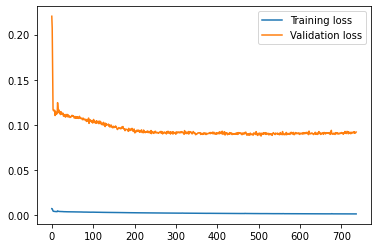

In [45]:
import matplotlib.pyplot as plt

plt.figure()
train['training_loss'].astype(float).plot(label='Training loss')
train['validation_loss'].astype(float).plot(label='Validation loss')
plt.legend()

plt.show()

In [55]:
submission = pd.read_csv('submission_gnn_first_iteration.csv')
submission['prediction'] = submission['prediction_y']
submission = submission[['customer_id', 'prediction']]        
submission = submission.fillna('')                            
print("Taille du df: ", submission.shape)
print("Taille des échantillons nuls: ", submission[submission['prediction'] == ''].shape)

Taille du df:  (1371980, 2)
Taille des échantillons nuls:  (1362589, 2)


In [56]:
submission.to_csv('submission_gnn_first_iteration.csv', index = False)

In [57]:
articles = pd.read_pickle("pickles/articles.pkl")

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,total_purchases,average_quantity,average_price,has_image
94089,0860833001,0860833,Runar sweater,252,Sweater,Garment Upper body,1010016,Solid,9,Black,...,Divided,51,Divided Basics,1002,Jersey Basic,Oversized top in soft sweatshirt fabric. Relax...,1310.0,1.08354,0.024223,True
